<a href="https://colab.research.google.com/github/ZieiN/Labs-in-Sirius/blob/main/My_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path Planning In the Environments with Dynamic Obstacles

In this lab we consider the problem of finding a (shortest) path in the environments with dynamic obstacles. The environment is represented by a grid composed of the free and blocked cells. The trajectories of dynamic obstacles are known and represented as a sequence of occupied cells in each time moment.

For simplicity it's assumed that the agent and dynamic obstacles can perform cardinal-only moves. They can also perform a wait action. All the actions have equal duration, so it's possible to discretize the timeline saying that at each time step the agent and dynamic obstacles can either move to one of the cardinal-adjacent cells or to stay in the same cell performing a wait-action.

The search-space state is described by tuple `<i, j, t>` where `i` and `j` are the cell's coordinates, `t` - time moment. So now theoretically there are an inifinite number of states corresponding to the same grid cell.

Your task is to implement A* algorithm with timesteps that avoids dynamic obstacles with known trajectories. 

In [54]:
import copy
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from heapq import heappop, heappush, heapify
from random import randint
import time
from PIL import Image, ImageDraw
from IPython.display import Image as Img
from sys import float_info
EPS = float_info.epsilon
%matplotlib notebook

In [55]:
'''Grid'''
class Map:

    # 
    def __init__(self):
        '''
        Default constructor
        '''

        self.width = 0
        self.height = 0
        self.cells = []
    

    def ReadFromString(self, cellStr, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self.width = width
        self.height = height
        self.cells = [[0 for _ in range(width)] for _ in range(height)]
        cellLines = cellStr.split("\n")
        i = 0
        j = 0
        for l in cellLines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self.cells[i][j] = 0
                    elif c == '#':
                        self.cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def SetGridCells(self, width, height, gridCells):
        '''
        Initialization of map by list of cells.
        '''
        self.width = width
        self.height = height
        self.cells = gridCells


    def inBounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self.width) and (0 <= i < self.height)
    

    def Traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self.cells[i][j]


    def GetNeighbors(self, i, j):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        '''
        neighbors = []
        dx = [1, -1, 0, 0, 0]
        dy = [0, 0, 1, -1, 0]
        for k in range(5):
          x = i+dx[k]
          y = j+dy[k]
          if self.inBounds(x, y) and self.Traversable(x, y):
            neighbors.append((x,y))
        return neighbors


### Search Node Representation



In [56]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node 
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    You might want to add other fields, methods for Node, depending on how you prefer to implement OPEN/CLOSED further on
    '''

    def __init__(self, coord, g = 0, h = 0, F = None, parent = None):
        self.i = coord[0]
        self.j = coord[1]
        self.g = g #equals t
        self.h = h
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
    
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j) and (self.g == other.g)
    
    def __lt__(self, other): #self < other (self has higher priority)
        return self.F < other.F or (abs(self.F - other.F) < EPS and (self.g > other.g))

In [57]:
class Open:

    def __init__(self):
        self.elements = []    
    def __iter__(self):
        return iter(self.elements)
    
    def __len__(self):
        return len(self.elements)

    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        return True

    def AddNode(self, item : Node, *args):
        '''
        AddNode is the method that puts (e.g. inserts or updates) the node to OPEN
        When implementing it do not forget to handle all possible cases:
         - node already in OPEN but the new g-value is better;
         - node already in OPEN but the new g-value is worse;
         - node is not in OPEN yet.
        '''
        for existingNode in self.elements:
            if existingNode.i == item.i and existingNode.j == item.j:
                if existingNode.g > item.g:
                    existingNode.g = item.g
                    existingNode.F = item.F
                    existingNode.parent = item.parent
                    return
                else:
                    return
        self.elements.append(item)
        return

    def GetBestNode(self, *args):
        '''
        GetBestNode is the method that 
         i) finds the best node, i.e. the one with the lowest f-value (f=g+h) (for Dijkstra h=0),
         ii) removes it from OPEN and 
         iii) returns it
        '''
        bestF = math.inf
        bestCoord = 0
        for i in range(len(self.elements)):
            if self.elements[i].F < bestF:
                bestCoord = i
                bestF = self.elements[i].F
                
        best = self.elements.pop(bestCoord)
        return best


In [58]:
class Closed:
    
    def __init__(self):
        self.elements = {}


    def __iter__(self):
        return iter(self.elements)

    def __len__(self):
        return len(self.elements)

    def AddNode(self, item : Node):
        '''
        AddNode is the method that inserts the node to CLOSED
        '''
        if self.WasExpanded(item):
          tmp = self.elements[(item.i, item.j, item.g)]
          if item.g < tmp:
            self.elements[(item.i, item.j, item.g)] = item.g
        else:
          self.elements[(item.i, item.j, item.g)] = item.g

    def WasExpanded(self, item : Node):
        '''
        WasExpanded is the method that checks if a node has been expanded
        '''
        return ((item.i, item.j) in self.elements)

    def GetNode(self, item):
        '''
        Finds node from Closed set by (i, j) coordinates on grid and returns it. Returns None if node was not found.
        '''
        return self.elements.get((item.i,item.j), None)

### A* with timesteps


In [59]:
def ManhattanDistance(i1, j1, i2, j2):
    return abs(i1 - i2) + abs(j1 - j2)

In [60]:
def MakePath(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [61]:
def CheckMove(i1, j1, i2, j2, t, obstacles):
    for obs in obstacles:
      if obs[t+1][0]==i2 and obs[t+1][1]==j2:
        return False
      if obs[t][0]==i2 and obs[t][1]==j2 and obs[t+1][0]==i1 and obs[t+1][1]==j1:
        return False
    return True

In [62]:
def AStarTimesteps(gridMap:Map, iStart:int, jStart:int, iGoal:int, jGoal:int, obstacles:list):
#TODO
    OPEN = Open()
    CLOSED = Closed()
    st = Node((iStart, jStart))
    OPEN.AddNode(st)
    while not OPEN.isEmpty():
      current = OPEN.GetBestNode()
      if CLOSED.WasExpanded(current):
        continue
      CLOSED.AddNode(current)
      if current.i == iGoal and current.j == jGoal:
        return (True, current, CLOSED.elements, OPEN)
      neb = gridMap.GetNeighbors(current.i, current.j)
      for state in neb:
        if CheckMove(current.i, current.j, state[0], state[1], current.g, obstacles):
          new_state = Node((state[0], state[1]))
          new_state.g = current.g + 1
          new_state.h = ManhattanDistance(new_state.i, new_state.j, iGoal, jGoal)
          new_state.F = new_state.g + new_state.h
          new_state.parent = current
          OPEN.AddNode(new_state)
    return False, None, CLOSED, OPEN

## Visualization

In [63]:
def Draw(gridMap : Map, paths : list, obstacles : list, filename = 'animated_trajectories'):
    '''
    Auxiliary function that visualizes the enviromnet, the agent and dynamic obstacles.
    '''
    k = 20
    quality = 5
    hIm = gridMap.height * k
    wIm = gridMap.width * k
    maxlen = 0
    for path in paths:
        maxlen = max(maxlen, len(path))
    step = 0
    images = []
    colors = [(randint(0,255), randint(0,255), randint(0,255)) for _ in range(len(paths))]
    while step < maxlen:
        for n in range(0, quality):
            im = Image.new('RGB', (wIm, hIm), color = 'white')
            draw = ImageDraw.Draw(im)
            for i in range(gridMap.height):
                for j in range(gridMap.width):
                    if(gridMap.cells[i][j] == 1):
                        draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))
            for i in range(len(paths)):
                curNode = paths[i][min(len(paths[i]) - 1, step)]
                nextNode = paths[i][min(len(paths[i]) - 1, step + min(n, 1))]
                draw.ellipse((float(curNode.j + n*(nextNode.j - curNode.j)/quality + 0.2) * k, 
                              float(curNode.i + n*(nextNode.i - curNode.i)/quality + 0.2) * k, 
                              float(curNode.j + n*(nextNode.j - curNode.j)/quality + 0.8) * k - 1, 
                              float(curNode.i + n*(nextNode.i - curNode.i)/quality + 0.8) * k - 1), 
                              fill=(0, 200, 200), width=0)
            for i in range(len(obstacles)):
                curNode = obstacles[i][min(len(obstacles[i]) - 1, step)]
                nextNode = obstacles[i][min(len(obstacles[i]) - 1, step + min(n, 1))]
                draw.ellipse((float(curNode[1] + n*(nextNode[1] - curNode[1])/quality + 0.2) * k, 
                              float(curNode[0] + n*(nextNode[0] - curNode[0])/quality + 0.2) * k, 
                              float(curNode[1] + n*(nextNode[1] - curNode[1])/quality + 0.8) * k - 1, 
                              float(curNode[0] + n*(nextNode[0] - curNode[0])/quality + 0.8) * k - 1), 
                              fill=(50, 50, 50), width=0)
            images.append(im)
        step += 1
    images[0].save('./'+filename+'.gif.png', save_all=True, append_images=images[1:], optimize=False, duration=500/quality, loop=0)

## Experimental evaluation

In [64]:
def SimpleTest(SearchFunction, task, heuristicFunction, *args):
    '''
    SimpleTest runs SearchFunction on one task (use a number from 0 to 5 to 
    choose a certain debug task on simple map or None to choose a random task 
    from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task

    Parameters:
        SearchGenerator (generator):
        task (int):

    Returns:
        pathFound (bool): Path was found or not.   
        length (Node): The length of the last found path.
    '''
    
    height = 15
    width = 30
    mapstr = '''
. . . # # . . . . . . . . # # . . . # . . # # . . . . . . .  
. . . # # # # # . . # . . # # . . . . . . # # . . . . . . . 
. . . . . . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # # # # . . . . 
. . . # # . . # . . # . . # # . . . # . . # # # # # . . . . 
. . . . . . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . . . . # . . . . . . . # . . . . . . . . . . . 
. . . # # # # # # # # # # # # # . # # . # # # # # # # . # # 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    taskMap = Map()
    taskMap.ReadFromString(mapstr, width, height)
    starts = [(1, 28), (2, 29), (3, 20), (3, 20), (0, 0)]
    goals = [(0, 1), (6, 2), (5, 6), (12, 0), (4, 23)]
    obstacles = []
    obstacles.append([(12,2), (11,2), (12,2), (13,2), (14,2), (13,2), (12,2), (11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2)])
    obstacles.append([(13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1)])    
    obstacles.append([(1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1)])
    obstacles.append([(7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2)])
    obstacles.append([(13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11)])
    obstacles.append([(11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16)])
    obstacles.append([(4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0)])
    obstacles.append([(10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21)])
    obstacles.append([(12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6)])
    obstacles.append([(12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27)])
    lengths = [54, 47, 48, 37, 56]

    if (task is None) or not (0 <= task < 5):
        task = randint(0, 4)

    start = Node(starts[task])
    goal = Node(goals[task])
    length = lengths[task]


    result = SearchFunction(taskMap, start.i, start.j, goal.i, goal.j, obstacles, *args)
    nodesExpanded = result[2]
    nodesOpened = result[3]
    if result[0]:
        path = MakePath(result[1])
        correct = int(path[1])  == int(length)
        print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
        Draw(taskMap, [path[0]], obstacles)
        return Img(filename = 'animated_trajectories.gif.png')
    else:
        print("Path not found!")



Path found! Length: 54. Nodes created: 2126. Number of steps: 1848. Correct: True
CPU times: user 2.01 s, sys: 21.7 ms, total: 2.03 s
Wall time: 2.04 s


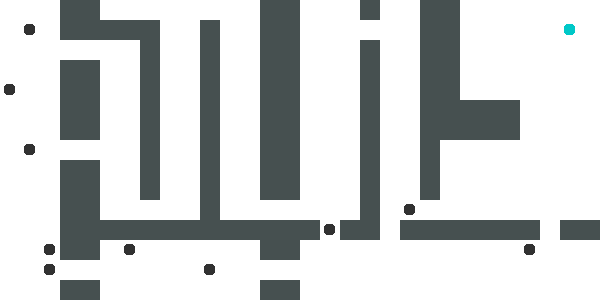

In [65]:
%time SimpleTest(AStarTimesteps, 0, ManhattanDistance)

Path found! Length: 47. Nodes created: 1578. Number of steps: 1366. Correct: True
CPU times: user 1.73 s, sys: 18.5 ms, total: 1.75 s
Wall time: 1.75 s


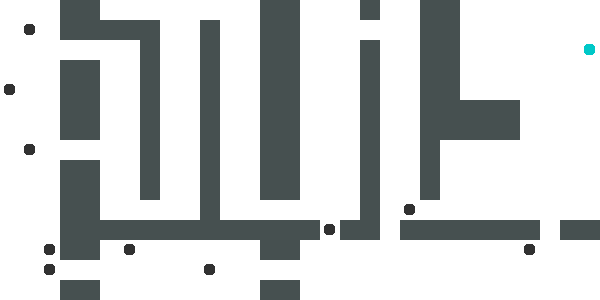

In [66]:
%time SimpleTest(AStarTimesteps, 1, ManhattanDistance)

Path found! Length: 48. Nodes created: 3600. Number of steps: 3316. Correct: True
CPU times: user 1.99 s, sys: 19.2 ms, total: 2.01 s
Wall time: 2.02 s


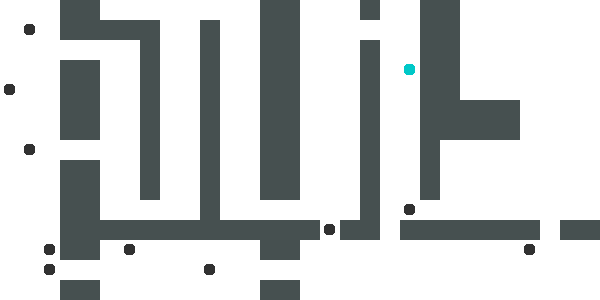

In [67]:
%time SimpleTest(AStarTimesteps, 2, ManhattanDistance)

Path found! Length: 37. Nodes created: 681. Number of steps: 551. Correct: True
CPU times: user 1.33 s, sys: 9.71 ms, total: 1.34 s
Wall time: 1.37 s


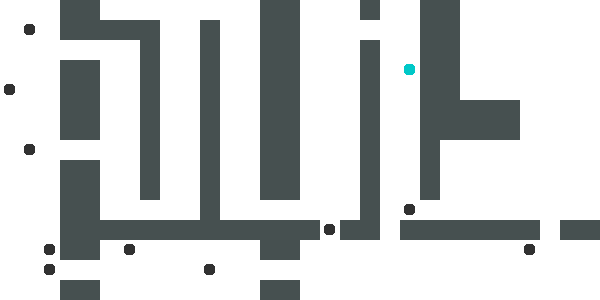

In [68]:
%time SimpleTest(AStarTimesteps, 3, ManhattanDistance)

Path found! Length: 56. Nodes created: 3264. Number of steps: 2990. Correct: True
CPU times: user 2.26 s, sys: 11.4 ms, total: 2.27 s
Wall time: 2.28 s


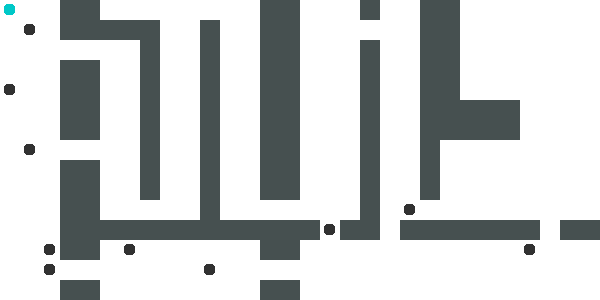

In [69]:
%time SimpleTest(AStarTimesteps, 4, ManhattanDistance)